# Convergence Test

Simulating  SA-OT with iterated learning to measure how quickly new learner agents born with different grammars adopt the grammar of a teacher (adult) agent. The goal is to understand how stable a target grammar is (in this case, Hierarchy 1) under transmission through GLA-based learning. We analyze:
- How many learning iterations are needed for agents starting from different grammars to converge to H1.
- How consistent that convergence is across multiple independent simulations.
- Whether certain starting grammars (e.g., H2 vs. H6) make convergence easier or harder. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from saot import *

In [ ]:
def run_convergence_test(n_runs=100, max_iters=300, k_values='default', verbose=False):
    """
    Runs SA-OT convergence tests simulating learning from an adult agent (H1) by learners
    starting with different grammars (H2 to H6).
    
    Args:
        n_runs (int): Number of independent simulation runs per starting grammar.
        max_iters (int): Maximum learning iterations per agent.
        k_values (str or list): Initial K-values for all agents, including adult.
        verbose (bool): Whether to print detailed output.
        
    Returns:
        all_learning_iters (np.ndarray): Convergence iteration counts (n_runs x 5 for H2-H6).
    """

    hierarchies = list(range(2, 7))  # H2 to H6
    n_agents = len(hierarchies)
    conv_iters_matrix = np.zeros((n_runs, n_agents))
    
    local_optima_per_run = []

    for run in range(n_runs):        
        if run % 10 == 0:
            print(f"Run {run + 1}/{n_runs}...")

        # Initialize the adult agent with the specified hierarchy and k-values
        adult_agent = SAOTAgent(id=0, hierarchy_name='H1', k_values=k_values)
        if verbose:
            print(f"Adult agent (H1): {adult_agent}")

        # Initialize a dictionary to store local optima produced by each agent while learning
        local_optima = {}

        # Iterate over hierarchies, creating a new agent for each
        for j, h in enumerate(hierarchies):
            # Create a new agent with the current hierarchy
            new_agent = SAOTAgent(id=h, hierarchy_name=f'H{h}', k_values=k_values)
            if verbose:
                print(f"\nNew agent (H{h}): {new_agent}")
            count = 0

            # The new agent learns from the adult agent until it converges to the same hierarchy
            while new_agent.hierarchy_name != adult_agent.hierarchy_name:
                if count > max_iters:
                    conv_iters_matrix[run, j] = np.nan  # did not converge
                    print(f"  At run {run+1} agent {new_agent.initial_hierarchy_name} did not converge after {max_iters} iterations.")
                    break
                count += 1
                observed_sf = adult_agent.produce_sf()
                new_agent.learn_from(observed_sf, verbose=False)
                if verbose:
                    print(f"Agent {new_agent.initial_hierarchy_name} after update {count}: {new_agent}")
            
            local_optima[f'Agent {new_agent.initial_hierarchy_name}'] = new_agent.local_optima_produced
            
            if verbose:
                print(f"Agent {new_agent.initial_hierarchy_name} settled on {new_agent.hierarchy_name} after {count} iterations.")
                print(f"Local optima produced: {new_agent.local_optima_produced}")

            if count <= max_iters:
                conv_iters_matrix[run, j] = count
        
        local_optima_per_run.append(local_optima)
        
    return conv_iters_matrix, local_optima_per_run

In [ ]:
n_runs = 100
hierarchies = list(range(2, 7))  # H2 to H6
labels = [f'H{h}' for h in hierarchies]

# Run simulations
print(f"Running convergence test with default k-values...")
conv_iters_matrix_default, local_optima_per_run_default = run_convergence_test(n_runs=n_runs, max_iters=300, k_values='default', verbose=False)
print(f"\nRunning convergence test with random float k-values...")
conv_iters_matrix_random, local_optima_per_run_random = run_convergence_test(n_runs=n_runs, max_iters=300, k_values='random', verbose=False)

assert conv_iters_matrix_default.shape == (n_runs, len(hierarchies)), "Shape mismatch for default K-values."
assert conv_iters_matrix_random.shape == (n_runs, len(hierarchies)), "Shape mismatch for random K-values."

Running convergence test with default k-values...
Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100...
Run 41/100...
Run 51/100...
Run 61/100...
Run 71/100...
Run 81/100...
Run 91/100...

Running convergence test with random float k-values...
Run 1/100...
Run 11/100...
Run 21/100...
Run 31/100...
Run 41/100...
Run 51/100...
Run 61/100...
Run 71/100...
Run 81/100...
Run 91/100...


C:\Users\Raya\AppData\Local\Temp\ipykernel_34748\1166594189.py:25: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(


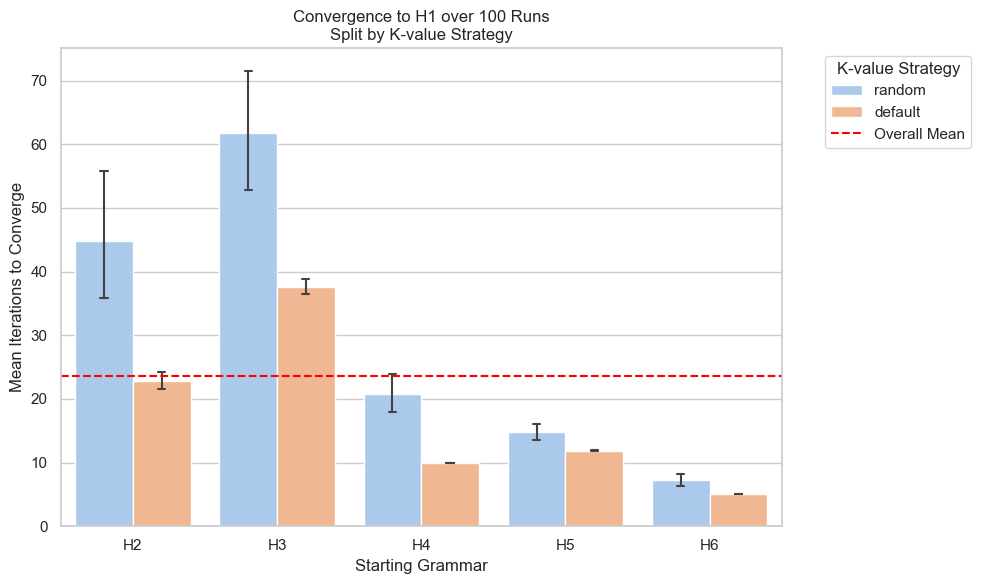

In [ ]:
# Create combined DataFrame
data = []

for run_idx in range(n_runs):
    for agent_idx, h in enumerate(hierarchies):
        data.append({
            'start_hierarchy': f'H{h}',
            'iterations': conv_iters_matrix_random[run_idx, agent_idx],
            'strategy': 'random'
        })
        data.append({
            'start_hierarchy': f'H{h}',
            'iterations': conv_iters_matrix_default[run_idx, agent_idx],
            'strategy': 'default'
        })

df = pd.DataFrame(data)


# ----- Barplot -----
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Barplot with automatic CI (95% by default)
ax = sns.barplot(
    data=df,
    x='start_hierarchy',
    y='iterations',
    hue='strategy',
    capsize=0.1,
    errwidth=1.5,
    errorbar='ci',  
    palette='pastel'
)

# Add global mean line
global_mean = df['iterations'].mean()
plt.axhline(global_mean, linestyle='--', color='red', label='Overall Mean')

plt.xlabel('Starting Grammar')
plt.ylabel('Mean Iterations to Converge')
plt.title(f'Convergence to H1 over {n_runs} Runs\nSplit by K-value Strategy')
plt.legend(title='K-value Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Agents' initial grammar seems to have a large effect on their learning rate given H1-generated learning data.

,start_hierarchy,iterations,strategy
0,H2,18.0,default
1,H2,93.0,random
2,H3,39.0,default
3,H3,13.0,random
4,H4,10.0,default


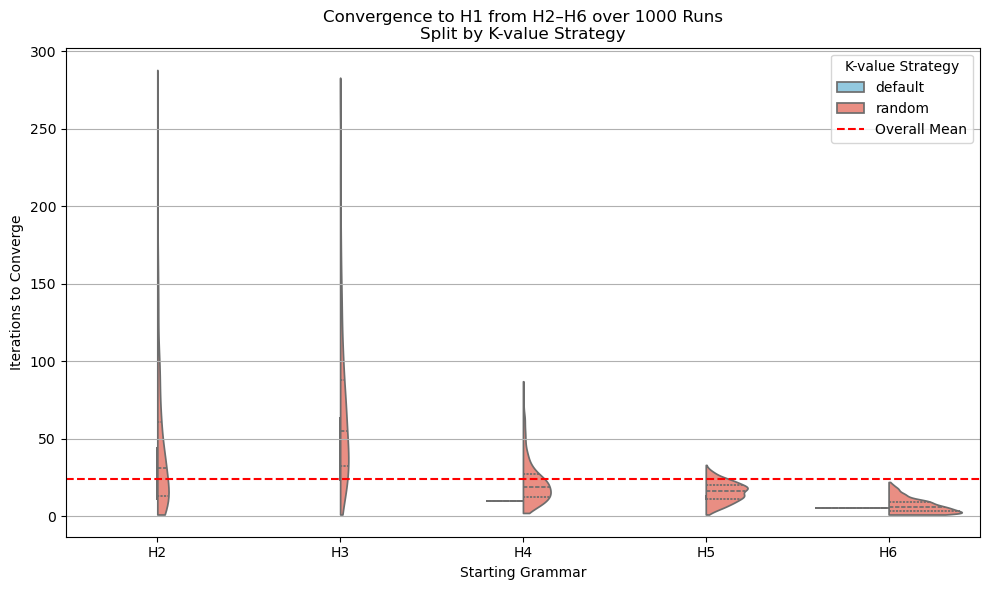

In [ ]:
# ----- Violin plot -----

# Combine results into one dataframe
data = []

for run_idx in range(n_runs):
    for agent_idx, h in enumerate(hierarchies):
        # Default strategy
        data.append({
            'start_hierarchy': f'H{h}',
            'iterations': conv_iters_matrix_default[run_idx, agent_idx],
            'strategy': 'default'
        })
        # Random strategy
        data.append({
            'start_hierarchy': f'H{h}',
            'iterations': conv_iters_matrix_random[run_idx, agent_idx],
            'strategy': 'random'
        })

df = pd.DataFrame(data)
display(df.head())


# ----- Plot violins -----
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=df,
    x='start_hierarchy',
    y='iterations',
    hue='strategy',
    split=True,
    inner='quartile',
    cut=0,
    palette={'default':'skyblue', 'random':'salmon'},
)

plt.axhline(df['iterations'].mean(), linestyle='--', color='red', label='Overall Mean')

plt.title(f'Convergence to H1 from H2–H6 over {n_runs} Runs\nSplit by K-value Strategy')
plt.xlabel("Starting Grammar")
plt.ylabel("Iterations to Converge")
plt.grid(axis='y')
plt.legend(title="K-value Strategy")
plt.tight_layout()
plt.show()


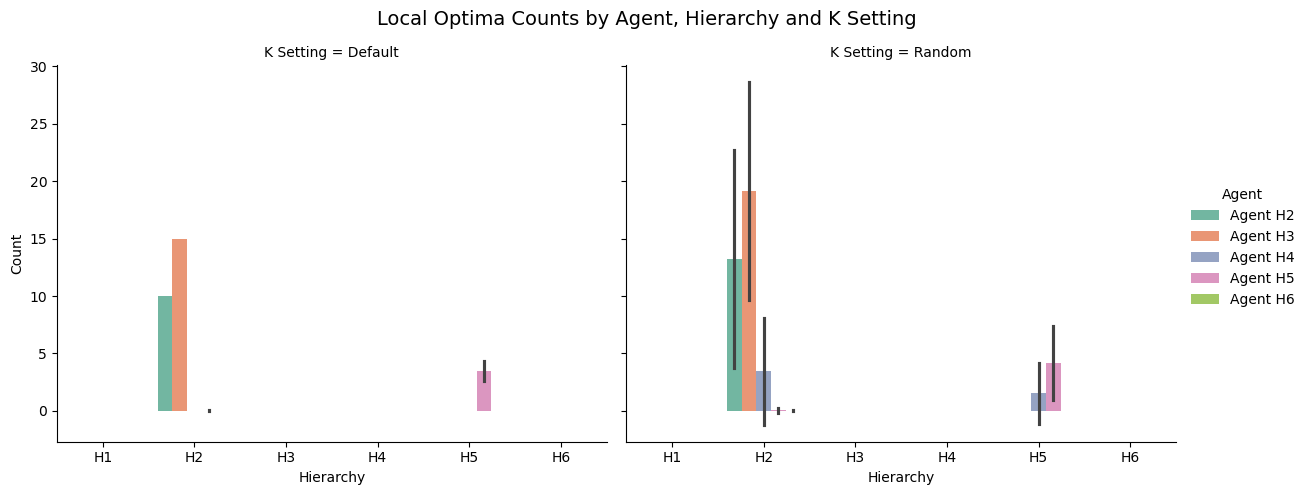

In [ ]:
from collections import defaultdict

def aggregate_local_optima_stats(local_optima_per_run):
    """Aggregare counts of local optima produced by agents across runs.
    
    Args:
        local_optima_per_run (list): List of dictionaries with local optima per agent per run.
        
    Returns:
        dict: Dictionary with agent names as keys and their local optima counts as values.
    """
    # Initialize nested dict: agent -> hierarchy -> list of counts
    aggregate_counts = defaultdict(lambda: defaultdict(list))
    
    # Accumulate counts for each agent and hierarchy across runs
    for run in local_optima_per_run:
        for agent, optima_dict in run.items():
            for h, opt in optima_dict.items():
                aggregate_counts[agent][h].append(len(opt))
    
    return aggregate_counts


def local_optima_stats(local_optima_per_run):
    """Compute mean counts and standard deviations of local optima produced by agents.
    
    Args:
        local_optima_per_run (list): List of dictionaries with local optima per agent per run.
        
    Returns:
        pd.DataFrame: DataFrame with mean counts and standard deviations of local optima per agent.
    """
    aggregate_counts = aggregate_local_optima_stats(local_optima_per_run)
    
    # Prepare data for DataFrame
    data = []
    for agent, hierarchies in aggregate_counts.items():
        for h, counts in hierarchies.items():
            mean_count = np.mean(counts)
            std_count = np.std(counts)
            data.append({
                'Agent': agent,
                'Hierarchy': h,
                'Mean Count': mean_count,
                'Std Dev': std_count
            })
    
    return pd.DataFrame(data)


def aggregate_counts_to_long_df(aggregate_counts, k_setting_name=None):
    """
    Convert aggregated counts dict to long-form DataFrame for seaborn plotting.
    
    Args:
        aggregate_counts (dict): nested dict as returned by aggregate_local_optima_stats
        k_setting_name (str, optional): Label for the K setting condition, if any.
        
    Returns:
        pd.DataFrame: with columns ['Agent', 'Hierarchy', 'Count', 'K Setting']
    """
    rows = []
    for agent, hierarchies in aggregate_counts.items():
        for hierarchy, counts in hierarchies.items():
            for count in counts:
                row = {
                    'Agent': agent,
                    'Hierarchy': hierarchy,
                    'Count': count
                }
                if k_setting_name is not None:
                    row['K Setting'] = k_setting_name
                rows.append(row)
    df = pd.DataFrame(rows)
    if 'K Setting' not in df.columns:
        df['K Setting'] = 'Unknown'  # default label if none provided
    return df



# Aggregate raw counts (nested dicts)
agg_default = aggregate_local_optima_stats(local_optima_per_run_default)
agg_random = aggregate_local_optima_stats(local_optima_per_run_random)

# Convert to long DataFrames with a label for each K setting
df_default = aggregate_counts_to_long_df(agg_default, k_setting_name="Default")
df_random = aggregate_counts_to_long_df(agg_random, k_setting_name="Random")

# Combine both conditions into a single DataFrame
df_all = pd.concat([df_default, df_random], ignore_index=True)

sns.catplot(
    data=df_all,
    kind='bar',
    x='Hierarchy',
    y='Count',
    hue='Agent',
    col='K Setting',
    errorbar='sd',    
    palette='Set2',
    dodge=True,
    height=5,
    aspect=1.2
)

plt.suptitle("Local Optima Counts by Agent, Hierarchy and K Setting", fontsize=14)
plt.subplots_adjust(top=0.87)  

plt.show()

As expected, lcoal optima are only produced with hierarchies representing mixed stages (H2 and H5). 

In [ ]:
def convergence_test_productions(learning_iters=30, production_sample=100, observed_sf = ['SN', 'V'], k_values='default', verbose=False):
    """
    Runs SA-OT convergence tests simulating learning from an adult agent (H1) by learners
    starting with different grammars (H2 to H6).
    
    Args:
        n_runs (int): Number of independent simulation runs per starting grammar.
        learning_iters (int): Number of learning iterations per agent.
        k_values (str or list): Initial K-values for all agents, including adult.
        verbose (bool): Whether to print detailed output.
        
    Returns:
    """

    hierarchies = list(range(2, 7))  # H2 to H6
    n_agents = len(hierarchies)

    production_history = {f'H{h}': [] for h in hierarchies}
    
    # Iterate over hierarchies, creating a new agent for each
    for j, h in enumerate(hierarchies):
        # Create a new agent with the current hierarchy
        new_agent = SAOTAgent(id=h, hierarchy_name=f'H{h}', k_values=k_values)
        if verbose:
            print(f"\nNew agent (H{h}): {new_agent}")

        # The new agent goes through the specified number of learning iterations
        for i in range(learning_iters):
            new_agent.learn_from(observed_sf, verbose=False)
            if verbose:
                print(f"Agent {new_agent.initial_hierarchy_name} after update {i+1}: {new_agent}")
        
        # Record productions for the current agent
        for _ in range(production_sample):
            produced_sf = new_agent.produce_sf()          
            production_history[f'H{h}'].append(serialize_sf(produced_sf, flat=True))
    
    return production_history


def run_multiple_convergence_tests(n_runs=10, learning_iters=30, production_sample=100, observed_sf=['SN', 'V'], k_values='default', verbose=False):
    all_counts = []

    for run in range(n_runs):
        if verbose or run % 10 == 0:
            print(f"\n--- Run {run+1} ---")

        production_history = convergence_test_productions(
            learning_iters=learning_iters, 
            production_sample=production_sample, 
            observed_sf=observed_sf, 
            k_values=k_values, 
            verbose=verbose
        )

        # Convert to DataFrame
        production_df = pd.DataFrame(production_history).melt(var_name='Initial Hierarchy', value_name='Surface Form')
        
        # Count occurrences of each surface form per hierarchy
        surface_form_counts = (
            production_df.groupby(['Initial Hierarchy', 'Surface Form'])
            .size()
            .reset_index(name='Count')
        )
        surface_form_counts['Run'] = run
        all_counts.append(surface_form_counts)

    return pd.concat(all_counts, ignore_index=True)

# Example usage
stats = run_multiple_convergence_tests(n_runs=10, learning_iters=30, production_sample=100, verbose=False)
stats_display = stats.pivot_table(index='Surface Form', columns='Initial Hierarchy', values='Count', fill_value=0)
print(stats_display)


--- Run 1 ---
Initial Hierarchy     H2    H3     H4     H5     H6
Surface Form                                       
[SN V SN]            0.0  44.9    0.0    0.0    0.0
[SN V]             100.0  55.1  100.0  100.0  100.0



--- Sweeping Learning Iterations: 20 ---

--- Run 1 ---

--- Run 11 ---

--- Run 21 ---

--- Run 31 ---

--- Run 41 ---

--- Run 51 ---

--- Run 61 ---

--- Run 71 ---

--- Run 81 ---

--- Run 91 ---

--- Sweeping Learning Iterations: 25 ---

--- Run 1 ---

--- Run 11 ---

--- Run 21 ---

--- Run 31 ---

--- Run 41 ---

--- Run 51 ---

--- Run 61 ---

--- Run 71 ---

--- Run 81 ---

--- Run 91 ---

--- Sweeping Learning Iterations: 30 ---

--- Run 1 ---

--- Run 11 ---

--- Run 21 ---

--- Run 31 ---

--- Run 41 ---

--- Run 51 ---

--- Run 61 ---

--- Run 71 ---

--- Run 81 ---

--- Run 91 ---

--- Sweeping Learning Iterations: 35 ---

--- Run 1 ---

--- Run 11 ---

--- Run 21 ---

--- Run 31 ---

--- Run 41 ---

--- Run 51 ---

--- Run 61 ---

--- Run 71 ---

--- Run 81 ---

--- Run 91 ---

--- Sweeping Learning Iterations: 40 ---

--- Run 1 ---

--- Run 11 ---

--- Run 21 ---

--- Run 31 ---

--- Run 41 ---

--- Run 51 ---

--- Run 61 ---

--- Run 71 ---

--- Run 81 ---

--- Run 91

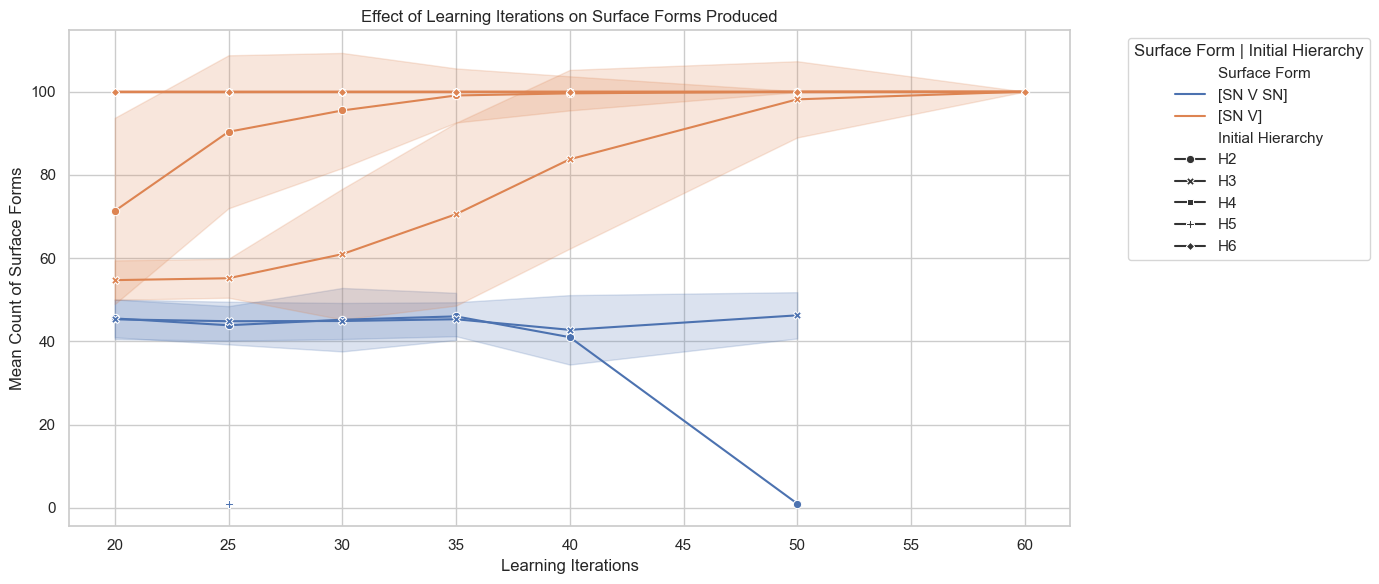

In [ ]:
def sweep_learning_iters(iters_list, n_runs=10, production_sample=100, observed_sf=['SN', 'V'], k_values='default'):
    sweep_results = []

    for iters in iters_list:
        print(f"\n--- Sweeping Learning Iterations: {iters} ---")
        run_df = run_multiple_convergence_tests(
            n_runs=n_runs,
            learning_iters=iters,
            production_sample=production_sample,
            observed_sf=observed_sf,
            k_values=k_values,
            verbose=False
        )
        run_df['Learning Iters'] = iters
        sweep_results.append(run_df)

    return pd.concat(sweep_results, ignore_index=True)


def plot_surface_form_evolution(df):
    plt.figure(figsize=(14, 6))
    sns.set(style="whitegrid")

    ax = sns.lineplot(
        data=df,
        x='Learning Iters',
        y='Count',
        hue='Surface Form',              # Color by Surface Form
        style='Initial Hierarchy',       # Marker by Initial Hierarchy
        markers=True,
        dashes=False,
        err_style="band",                # Confidence interval as band
        errorbar='sd',                   # Use standard deviation for error bands
        estimator='mean'                 # Plot the mean over runs
    )

    plt.title('Effect of Learning Iterations on Surface Forms Produced')
    plt.ylabel('Mean Count of Surface Forms')
    plt.xlabel('Learning Iterations')
    plt.legend(title='Surface Form | Initial Hierarchy', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# Define the list of learning iterations to sweep
learning_iters_list = [20, 25, 30, 35, 40, 50, 60]
sweep_df = sweep_learning_iters(learning_iters_list, n_runs=100, production_sample=100)

# Plot with SD error bands
plot_surface_form_evolution(sweep_df)